<a href="https://colab.research.google.com/github/rayenayari/news_categorization/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sklearn
import os
from os import listdir
print(listdir('./'))
#from google.colab import drive
#drive.mount('/content/gdrive')


['.git', '.DS_Store', 'News_Category_Dataset_v2.json', 'README.md', 'bert', 'notebook.ipynb', 'out', 'install_conda.sh', '.ipynb_checkpoints', 'rnn', 'XLNet']


The dataset is initially formatted as a Json list. We need to transform it to a pandas Dataframe

In [2]:
import matplotlib.pyplot as plt
#import keras
plt.rcParams['figure.figsize'] = (16,10)
df = pd.read_json('./News_Category_Dataset_v2.json', lines=True)
df.head(4)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26


Let's see the columns:

In [3]:
columns=df.columns
print("Total number of columns {}".format(len(columns)))

Total number of columns 6


For efficiency purposes, we will only use the category and the headline columns. 

In [4]:
df["headline"]+=" "+df.short_description
df=df[["category","headline"]]

df.head(4)

,category,headline
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...


We need to merge the worldpost and world post.
We merge similar categories to get a more uniform distribution.
For example, business and money become business and Finance

In [5]:
df=df.copy()
#df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x )
df['category']=df['category'].replace({"HEALTHY LIVING": "WELLNESS",
"QUEER VOICES": "GROUPS VOICES",
"BUSINESS": "BUSINESS & FINANCES",
"PARENTS": "PARENTING",
"BLACK VOICES": "GROUPS VOICES",
"THE WORLDPOST": "WORLD NEWS",
"STYLE": "STYLE & BEAUTY",
"GREEN": "ENVIRONMENT",
"TASTE": "FOOD & DRINK",
"WORLDPOST": "WORLD NEWS",
"SCIENCE": "SCIENCE & TECH",
"TECH": "SCIENCE & TECH",
"MONEY": "BUSINESS & FINANCES",
"ARTS": "ARTS & CULTURE",
"COLLEGE": "EDUCATION",
"LATINO VOICES": "GROUPS VOICES",
"CULTURE & ARTS": "ARTS & CULTURE",
"FIFTY": "MISCELLANEOUS",
"GOOD NEWS": "MISCELLANEOUS"})

In [6]:
categories=df.groupby("category")
print("Total number of categories: {}".format(categories.ngroups))

Total number of categories: 26


We rename the columns: category-> y and headline-> text

In [7]:
df=df.rename(columns={"headline":"text","category":'y'})
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 
#we print 2 rows
df.sample(2)


,y,text
76558,BUSINESS & FINANCES,Why Do Some Borrowers Pay Higher Mortgage Inte...
40882,POLITICS,A Lesson In Civility For Senator Jeff Sessions...


We need to convert category to id

In [8]:
# category to id
categories = ["POLITICS","WELLNESS","ENTERTAINMENT","PARENTING","GROUPS VOICES",'STYLE & BEAUTY','TRAVEL','WORLD NEWS','FOOD & DRINK','BUSINESS & FINANCES','COMEDY',
           'SPORTS','SCIENCE & TECH','HOME & LIVING','ENVIRONMENT','ARTS & CULTURE','WEDDINGS','WOMEN','IMPACT','DIVORCE','CRIME','MEDIA','MISCELLANEOUS','WEIRD NEWS','RELIGION','EDUCATION']
print(categories)
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['y'].apply(lambda x: category_int[x])
category_int


['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'PARENTING', 'GROUPS VOICES', 'STYLE & BEAUTY', 'TRAVEL', 'WORLD NEWS', 'FOOD & DRINK', 'BUSINESS & FINANCES', 'COMEDY', 'SPORTS', 'SCIENCE & TECH', 'HOME & LIVING', 'ENVIRONMENT', 'ARTS & CULTURE', 'WEDDINGS', 'WOMEN', 'IMPACT', 'DIVORCE', 'CRIME', 'MEDIA', 'MISCELLANEOUS', 'WEIRD NEWS', 'RELIGION', 'EDUCATION']


{'POLITICS': 0,
 'WELLNESS': 1,
 'ENTERTAINMENT': 2,
 'PARENTING': 3,
 'GROUPS VOICES': 4,
 'STYLE & BEAUTY': 5,
 'TRAVEL': 6,
 'WORLD NEWS': 7,
 'FOOD & DRINK': 8,
 'BUSINESS & FINANCES': 9,
 'COMEDY': 10,
 'SPORTS': 11,
 'SCIENCE & TECH': 12,
 'HOME & LIVING': 13,
 'ENVIRONMENT': 14,
 'ARTS & CULTURE': 15,
 'WEDDINGS': 16,
 'WOMEN': 17,
 'IMPACT': 18,
 'DIVORCE': 19,
 'CRIME': 20,
 'MEDIA': 21,
 'MISCELLANEOUS': 22,
 'WEIRD NEWS': 23,
 'RELIGION': 24,
 'EDUCATION': 25}

We see the composition of the dataset. This would be helpful to draw conclusions about the accuracy of our model(s).
Clearly, we expect a better accuracy for politics categorization.

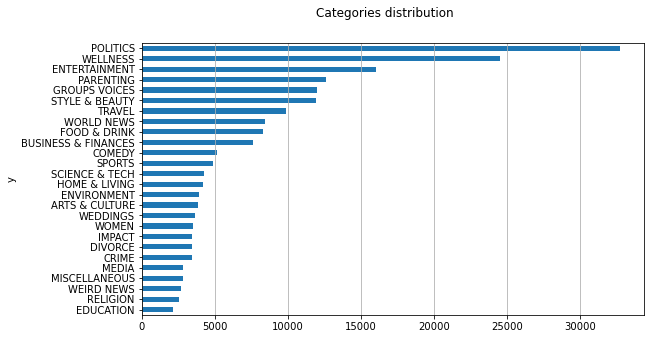

In [9]:
fig, ax = plt.subplots(figsize=(9,5))
fig.suptitle("Categories distribution", fontsize=12)
df["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Preprocessing the data:

We need to clean the data:
- We merge categories that are very close
- We remove stop words and we apply lemmatization (used from towardsdatascience)

In [10]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
import re
nltk.download('wordnet')
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text
utils_preprocess_text("ray an", flg_stemm=False, flg_lemm=True, lst_stopwords=["ray"])

[nltk_data] Downloading package wordnet to /home/rayari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'an'

Corpus stop words:

In [11]:
nltk.download('stopwords')
list_stopwords=nltk.corpus.stopwords.words("english")
list_stopwords[:10]

[nltk_data] Downloading package stopwords to /home/rayari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

We clean the dataset using the function written above:

In [12]:
df["clean_text"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=list_stopwords))

We compare text with clean text:

In [13]:
print("Text before cleaning: {}\n".format(df["text"][1]))
print("Text after cleaning: {}\n".format(df["clean_text"][1]))

Text before cleaning: Sisterhood: Powerful on Mars! I met three impressive Mars One women last weekend: Kenya Armbrister, Blake Bevin, and Megan Kane. These women are determined. They are distinctive in the skills and knowledge they'd bring to Mars. They are fun to talk to -- smart, personable, and lively. I'd go to Mars in a heartbeat with any or all of them.

Text after cleaning: sisterhood powerful mar met three impressive mar one woman last weekend kenya armbrister blake bevin megan kane woman determined distinctive skill knowledge theyd bring mar fun talk smart personable lively id go mar heartbeat



We delete empty and short data:

In [14]:
df["word_length"]=df.clean_text.apply(lambda x: len(x.split()))
df=df[df.word_length>=5]
df.head(4)

df.sample(2)

,y,text,c2id,clean_text,word_length
124824,ENTERTAINMENT,A Critical 'AHS: Freak Show' Script Has Been S...,2,critical ahs freak show script stolen,6
147064,GROUPS VOICES,"Frank Schubert, NOM Political Director, Calls ...",4,frank schubert nom political director call new...,21


Now, we divide the data into train/dev/test split according to 80/10/10

In [15]:
from sklearn.model_selection import train_test_split
X = df['clean_text']
y = df['c2id']
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [16]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(157952,)
(157952,)
(19744,)
(19744,)
(19745,)
(19745,)


(None, None)

In [17]:
import warnings
warnings.filterwarnings('ignore')


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 12000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train)

# Tokenize data
X_train_rnn = tok.texts_to_sequences(X_train)
X_test_rnn = tok.texts_to_sequences(X_test)

# Pad data
maxlen = 50
X_train_rnn = pad_sequences(X_train_rnn, maxlen=maxlen)
X_test_rnn = pad_sequences(X_test_rnn, maxlen=maxlen)

### RNN MODEL SUMMARY


In [19]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
model_before_tuning = Sequential(name="RNN_MODEL_WITHOUT_TUNING")
model_before_tuning.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model_before_tuning.add(Bidirectional(LSTM(128, return_sequences=True))) 
model_before_tuning.add(Bidirectional(LSTM(64, return_sequences=True)))
model_before_tuning.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model_before_tuning.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model_before_tuning.add(Dense(64))
model_before_tuning.add(Dropout(0.25))
model_before_tuning.add(Dense(26, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model_before_tuning.summary()


Model: "RNN_MODEL_WITHOUT_TUNING"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            384000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           164864    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)   

In [3]:
vocab_size = 12000
embed_size=32
maxlen=50
!pip install tensorflow

/bin/bash: pip: command not found


In [19]:
#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
checkpoint_filepath_no_tuning = './rnn/checkpoint_no_tuning'
model_before_tuning_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_no_tuning,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [21]:

#Compile and Fit Model
from sklearn.model_selection import GridSearchCV
model_before_tuning.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

history_before_tuning=model_before_tuning.fit(X_train_rnn, 
          y_train, 
          batch_size=256, 
          validation_data=(X_test_rnn, y_test), 
          epochs=20,callbacks=[model_before_tuning_checkpoint_callback])

Epoch 1/20
617/617 [==============================] - 21s 27ms/step - loss: 2.5416 - accuracy: 0.2940 - val_loss: 1.5698 - val_accuracy: 0.5682
Epoch 2/20
617/617 [==============================] - 15s 25ms/step - loss: 1.4688 - accuracy: 0.5997 - val_loss: 1.3250 - val_accuracy: 0.6382
Epoch 3/20
617/617 [==============================] - 15s 25ms/step - loss: 1.2021 - accuracy: 0.6693 - val_loss: 1.2540 - val_accuracy: 0.6554
Epoch 4/20
617/617 [==============================] - 15s 24ms/step - loss: 1.0604 - accuracy: 0.7063 - val_loss: 1.2310 - val_accuracy: 0.6614
Epoch 5/20
617/617 [==============================] - 15s 24ms/step - loss: 0.9651 - accuracy: 0.7294 - val_loss: 1.2172 - val_accuracy: 0.6637
Epoch 6/20
617/617 [==============================] - 15s 24ms/step - loss: 0.8964 - accuracy: 0.7475 - val_loss: 1.2420 - val_accuracy: 0.6630
Epoch 7/20
617/617 [==============================] - 15s 25ms/step - loss: 0.8390 - accuracy: 0.7628 - val_loss: 1.2721 - val_accuracy:

Let's see the results:

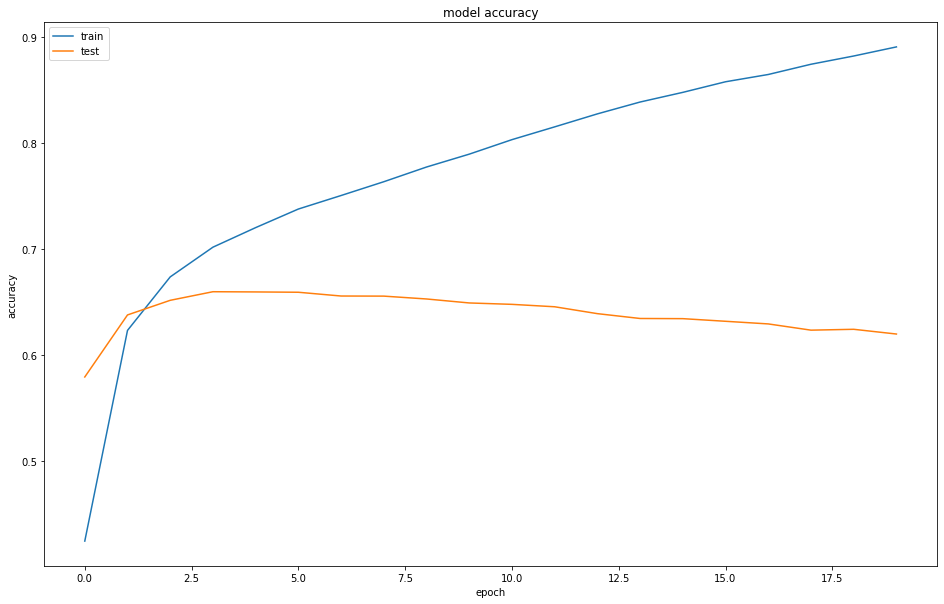

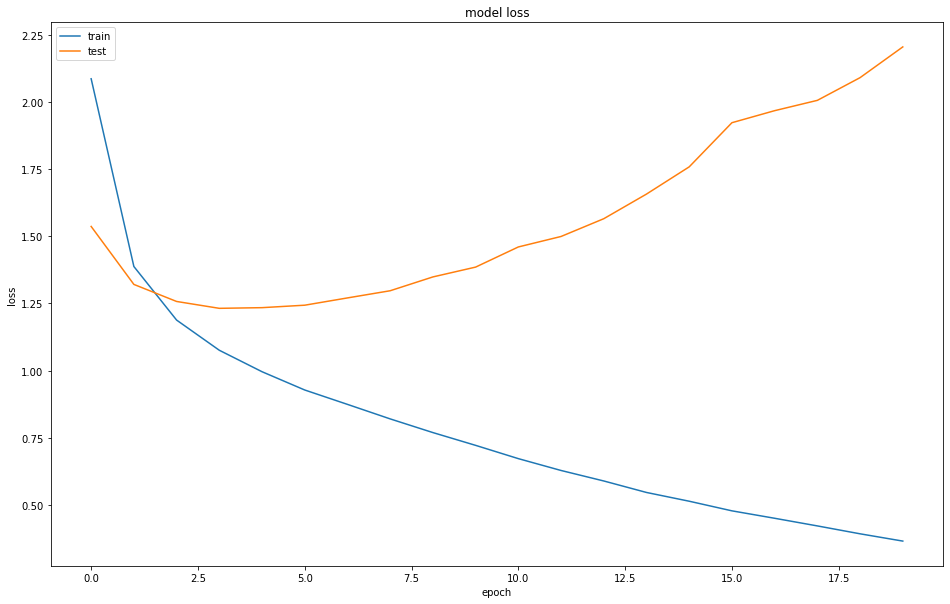

In [31]:
plt.plot(history_before_tuning.history['accuracy'])
plt.plot(history_before_tuning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_before_tuning.history['loss'])
plt.plot(history_before_tuning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's do some predictions

In [24]:
model_before_tuning.load_weights(checkpoint_filepath_no_tuning)
pred = model_before_tuning.predict(X_test_rnn) 
pred = np.argmax(pred, axis = 1) 
print(pred[:5]) 
print(y_test.to_list()[:5])

#mapping the encoded output to actual categories
predicted_category = [int_category[x] for x in pred]
true_category = [int_category[x] for x in y_test]
print(predicted_category[1])

[21  2 11  1  0]
[0, 2, 4, 8, 0]
ENTERTAINMENT


We build a PD containing the predictions:
We need to reconvert X_test back from sequence to text

In [25]:
result_df_rnn = pd.DataFrame({'description':tok.sequences_to_texts(X_test_rnn),'true_category':true_category, 'predicted_category':predicted_category})
result_df_rnn.head()

,description,true_category,predicted_category
0,newspaper front page usher uncertainty new tru...,POLITICS,MEDIA
1,dumped hard bachelor new bachelorette want fin...,ENTERTAINMENT,ENTERTAINMENT
2,ali open personally sad long time ali reflects...,GROUPS VOICES,SPORTS
3,food fear time year abundance dread together s...,FOOD & DRINK,WELLNESS
4,always protected even worst group white suprem...,POLITICS,POLITICS


In [26]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df_rnn['true_category'], result_df_rnn['predicted_category'])}")

Accuracy is 0.6637123322360091


We visualize the confusion matrix:

<AxesSubplot:>

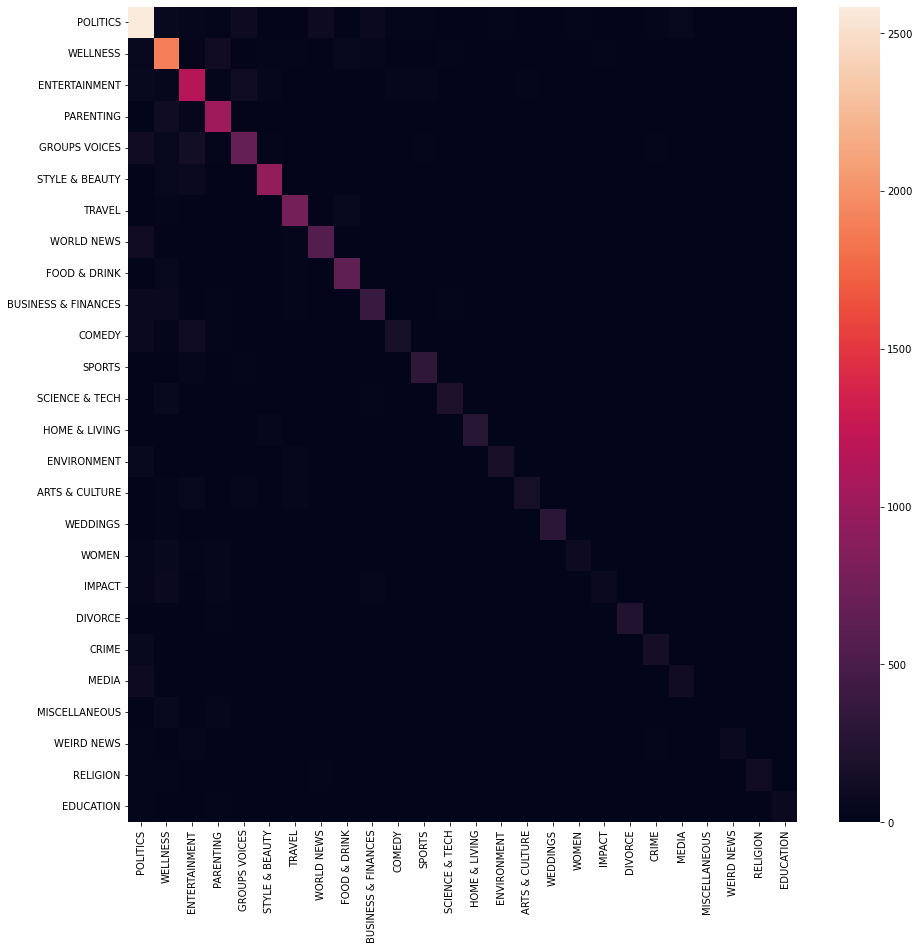

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(category_int))
df_cm = pd.DataFrame(confusion_mat, index = list(category_int),columns = list(category_int))
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(df_cm)

#### Hypertuning the Learning rate:

In [43]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#%conda install tensorflow
#import sys
#sys.executable
#!export PYTHONPATH="/scratch_net/narigpu01//rayari/conda_envs/ENVML/bin/python"
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8157031835497535800,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9654677056
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 3450612255073725207
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10529944384
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 6434388177557514946
 physical_device_desc: "device: 1, name: TITAN X (Pascal), pci bus id: 0000:05:00.0, compute capability: 6.1",
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10529944384
 locality {
   bus_id: 2
   numa_node: 1
   links {
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/cuda
!export TF_XLA_FLAGS="--tf_xla_auto_jit=2"
print(tf.test.is_built_with_cuda())
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

Num GPUs Available:  4
True


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(learn_rate=0.01):
	# create model
  model = Sequential()
  model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
  model.add(Bidirectional(LSTM(128, return_sequences=True))) 
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
  model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
  model.add(Dense(64))
  model.add(Dropout(0.25))
  model.add(Dense(26, activation='softmax'))  
	# Compile model
  optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
  model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer=optimizer, 
              metrics=['accuracy']) 
  return model
  # create model
model = KerasClassifier(build_fn=create_model, epochs=2, batch_size=256, verbose=0)
# define the grid search parameters
learn_rate = [3e-4,7e-4 ,0.001, 0.005, 0.008, 0.12]

param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2)
grid_result = grid.fit(X_train_rnn, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


2021-11-28 18:59:05.662648: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-28 18:59:05.669898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-28 18:59:06.865239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-28 18:59:06.891567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-28 18:59:06.933854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2021-11-28 18:59:06.942073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:05:00.0 na

2021-11-28 18:59:10.591276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-28 18:59:10.591319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 1 2 3 
2021-11-28 18:59:10.591326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N Y N N 
2021-11-28 18:59:10.591330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 1:   Y N N N 
2021-11-28 18:59:10.591334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 2:   N N N Y 
2021-11-28 18:59:10.591337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 3:   N N Y N 
2021-11-28 18:59:10.600038: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-11-28 18:59:10.600095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/t

Best: 0.669165 using {'learn_rate': 0.005}
0.452315 (0.020993) with: {'learn_rate': 0.0003}
0.591889 (0.006115) with: {'learn_rate': 0.0007}
0.617124 (0.003625) with: {'learn_rate': 0.001}
0.669165 (0.003173) with: {'learn_rate': 0.005}
0.668589 (0.002962) with: {'learn_rate': 0.008}
0.157839 (0.018615) with: {'learn_rate': 0.12}


Let's try to narrow the interval between 0.001 and 0.009:

In [34]:
  # create model
model = KerasClassifier(build_fn=create_model, epochs=2, batch_size=256, verbose=0)
# define the grid search parameters
learn_rate = [2e-3,5e-3 ,6e-3,65e-4, 7e-3, 9e-3]

param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2)
grid_result = grid.fit(X_train_rnn, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


2021-11-19 18:46:57.588001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 18:46:57.588001: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 18:46:58.727104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-19 18:46:58.777576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2021-11-19 18:46:58.780094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:05:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2

2021-11-19 18:47:02.217115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-19 18:47:02.217160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 1 2 3 
2021-11-19 18:47:02.217167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N Y N N 
2021-11-19 18:47:02.217172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 1:   Y N N N 
2021-11-19 18:47:02.217175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 2:   N N N Y 
2021-11-19 18:47:02.217179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 3:   N N Y N 
2021-11-19 18:47:02.225910: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-11-19 18:47:02.225974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/t

Best: 0.670824 using {'learn_rate': 0.007}
0.654788 (0.002224) with: {'learn_rate': 0.002}
0.668045 (0.001265) with: {'learn_rate': 0.005}
0.668785 (0.001741) with: {'learn_rate': 0.006}
0.669805 (0.001148) with: {'learn_rate': 0.0065}
0.670824 (0.003028) with: {'learn_rate': 0.007}
0.666475 (0.001909) with: {'learn_rate': 0.009}


Let's try to narrow the interval between 0.0065 and 0.0072:

In [35]:
  # create model
model = KerasClassifier(build_fn=create_model, epochs=2, batch_size=256, verbose=0)
# define the grid search parameters
learn_rate = [66e-4,67e-4, 68e-4,69e-4,71e-4,72e-4]

param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)
grid_result = grid.fit(X_train_rnn, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

2021-11-19 19:03:31.560124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 19:03:31.560124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 19:03:31.564454: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 19:03:31.564453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 19:03:32.730517: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-19 19:03:32.732094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-19 19:03:32.732094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcud

2021-11-19 19:03:33.247867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0, 1, 2, 3
2021-11-19 19:03:33.248362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0, 1, 2, 3
2021-11-19 19:03:33.248419: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-19 19:03:33.248845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-19 19:03:33.250150: I te

2021-11-19 19:03:38.425764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-19 19:03:38.425821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 1 2 3 
2021-11-19 19:03:38.425829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N Y N N 
2021-11-19 19:03:38.425834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 1:   Y N N N 
2021-11-19 19:03:38.425838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 2:   N N N Y 
2021-11-19 19:03:38.425842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 3:   N N Y N 
2021-11-19 19:03:38.435121: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-11-19 19:03:38.435206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/t

2021-11-19 19:03:39.341486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 19:03:39.410279: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 19:03:39.417303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 19:03:39.425402: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 19:03:43.452535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-19 19:03:43.456691: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-19 19:03:43.533790: I tensorflow/stream_executor/platform/default/dso_loader.cc:

Best: 0.670431 using {'learn_rate': 0.0069}
0.669691 (0.002577) with: {'learn_rate': 0.0066}
0.669203 (0.001333) with: {'learn_rate': 0.0067}
0.670020 (0.001471) with: {'learn_rate': 0.0068}
0.670431 (0.002477) with: {'learn_rate': 0.0069}
0.668304 (0.002561) with: {'learn_rate': 0.0071}
0.668602 (0.002011) with: {'learn_rate': 0.0072}


#### Clearly, the best learning rate is 0.007

#### Hypertuning Batch size:


In [22]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib
#rayari@narigpu01:~$ export TF_XLA_FLAGS=--tf_xla_enable_xla_devices
def create_model():
	# create model
  model = Sequential()
  model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
  model.add(Bidirectional(LSTM(128, return_sequences=True))) 
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
  model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
  model.add(Dense(64))
  model.add(Dropout(0.25))
  model.add(Dense(26, activation='softmax'))
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.007)
	# Compile model
  
  model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer=optimizer, 
              metrics=['accuracy']) 
  return model
  # create model
model = KerasClassifier(build_fn=create_model, epochs=2, batch_size=256, verbose=0)
# define the grid search parameters
batch_size = [16,32,64,128,256,512]

param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)
grid_result = grid.fit(X_train_rnn, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

2021-11-23 15:14:27.593194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-23 15:14:27.599597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-23 15:14:27.599597: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-23 15:14:27.626081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-23 15:14:28.764412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-23 15:14:28.770957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-23 15:14:28.771778: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcud

2021-11-23 15:14:29.213717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:05:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 447.48GiB/s
2021-11-23 15:14:29.219278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0, 1, 2, 3
2021-11-23 15:14:29.219802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-23 15:14:29.224095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:83:00.0 name: TITAN X (Pascal) computeCapability: 6.1
coreClock: 1.531GHz coreCount: 28 deviceMemory

2021-11-23 15:14:34.587333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-23 15:14:34.587394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 1 2 3 
2021-11-23 15:14:34.587408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N Y N N 
2021-11-23 15:14:34.587413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 1:   Y N N N 
2021-11-23 15:14:34.587417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 2:   N N N Y 
2021-11-23 15:14:34.587420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 3:   N N Y N 
2021-11-23 15:14:34.596062: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-11-23 15:14:34.596143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/t

2021-11-23 15:14:35.512176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 15:14:35.533733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 15:14:35.585366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 15:14:35.600128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-23 15:14:39.600991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-23 15:14:39.602204: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-23 15:14:39.606178: I tensorflow/stream_executor/platform/default/dso_loader.cc:

Best: 0.668906 using {'batch_size': 256}
0.631958 (0.014263) with: {'batch_size': 16}
0.660796 (0.004128) with: {'batch_size': 32}
0.668184 (0.003568) with: {'batch_size': 64}
0.666082 (0.002153) with: {'batch_size': 128}
0.668906 (0.003635) with: {'batch_size': 256}
0.665892 (0.003719) with: {'batch_size': 512}


### Results: Before and After Hypertuning Learning Rate

In [83]:
model_after_tuning = Sequential(name="RNN_MODEL_WITH_TUNING")
model_after_tuning.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model_after_tuning.add(Bidirectional(LSTM(128, return_sequences=True))) 
model_after_tuning.add(Bidirectional(LSTM(64, return_sequences=True)))
model_after_tuning.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model_after_tuning.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model_after_tuning.add(Dense(64))
model_after_tuning.add(Dropout(0.25))
model_after_tuning.add(Dense(26, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model_after_tuning.summary()
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.007)
model_after_tuning.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer=optimizer1,
              metrics=['accuracy']) 

Model: "RNN_MODEL_WITH_TUNING"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 32)            384000    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 50, 256)           164864    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 50, 128)           164352    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 128)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)      

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.007>

In [87]:
model_after_tuning=create_model(learn_rate=0.007)
checkpoint_filepath_tuning = './rnn/checkpoint_with_tuning'
model_after_tuning_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_tuning,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history_after_tuning=model_after_tuning.fit(X_train_rnn, 
          y_train, 
          batch_size=256, 
          validation_data=(X_test_rnn, y_test), 
          epochs=20,callbacks=[model_after_tuning_checkpoint_callback])

Epoch 1/20
617/617 [==============================] - 19s 26ms/step - loss: 2.0702 - accuracy: 0.4329 - val_loss: 1.2094 - val_accuracy: 0.6687
Epoch 2/20
617/617 [==============================] - 15s 24ms/step - loss: 1.1543 - accuracy: 0.6815 - val_loss: 1.1382 - val_accuracy: 0.6799
Epoch 3/20
617/617 [==============================] - 15s 24ms/step - loss: 1.0011 - accuracy: 0.7175 - val_loss: 1.1453 - val_accuracy: 0.6802
Epoch 4/20
617/617 [==============================] - 15s 24ms/step - loss: 0.8761 - accuracy: 0.7511 - val_loss: 1.1620 - val_accuracy: 0.6790
Epoch 5/20
617/617 [==============================] - 15s 24ms/step - loss: 0.7755 - accuracy: 0.7770 - val_loss: 1.2036 - val_accuracy: 0.6755
Epoch 6/20
617/617 [==============================] - 15s 24ms/step - loss: 0.6926 - accuracy: 0.8012 - val_loss: 1.2634 - val_accuracy: 0.6704
Epoch 7/20
617/617 [==============================] - 15s 24ms/step - loss: 0.6184 - accuracy: 0.8199 - val_loss: 1.3522 - val_accuracy:

In [88]:
model_before_tuning.load_weights(checkpoint_filepath_no_tuning)
model_after_tuning.load_weights(checkpoint_filepath_tuning)


In [89]:
score_before_tuning=model_before_tuning.evaluate(X_test_rnn, y_test)
score_after_tuning=model_after_tuning.evaluate(X_test_rnn, y_test)


618/618 [==============================] - 6s 10ms/step - loss: 1.1453 - accuracy: 0.6802


In [61]:
# Tokenize data
X_valid_rnn = tok.texts_to_sequences(X_valid)
X_valid_rnn= pad_sequences(X_valid_rnn, maxlen=maxlen)
val_score_no_tuning=model_before_tuning.evaluate(X_valid_rnn,y_valid)
val_score_tuning=model_after_tuning.evaluate(X_valid_rnn,y_valid)

617/617 [==============================] - 7s 10ms/step - loss: 1.3497 - accuracy: 0.6576


In [82]:
#model_before_tuning.optimizer.learning_rate
model_after_tuning.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

#### Accuracy and Loss:

In [5]:
# before tuning
acc_before_tuning = history_before_tuning.history['accuracy']
val_acc_before_tuning = history_before_tuning.history['val_accuracy']
loss_before_tuning = history_before_tuning.history['loss']
val_loss_before_tuning = history_before_tuning.history['val_loss']
# after tuning
acc_after_tuning = history_after_tuning.history['accuracy']
val_acc_after_tuning = history_after_tuning.history['val_accuracy']
loss_after_tuning = history_after_tuning.history['loss']
val_loss_after_tuning = history_after_tuning.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy ')
plt.plot(epochs, acc_before_tuning, 'red', label='Training acc bef tuning')
plt.plot(epochs, val_acc_before_tuning, 'blue', label='Validation acc bef tuning')
plt.plot(epochs, acc_after_tuning, '--', label='Training acc after tuning')
plt.plot(epochs, val_acc_after_tuning, '--', label='Validation acc after tuning')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss_before_tuning, 'red', label='Training loss before tuning')
plt.plot(epochs, val_loss_before_tuning, 'blue', label='Validation loss before tuning')
plt.plot(epochs, loss_after_tuning, 'red', label='Training loss after tuning')
plt.plot(epochs, val_loss_after_tuning, 'blue', label='Validation loss after tuning')
plt.legend()

plt.show()

NameError: name 'history_before_tuning' is not defined

In [62]:
from sklearn.metrics import classification_report
# Predictions:
pred_before_tuning = model_before_tuning.predict(X_test_rnn) 
pred_before_tuning = np.argmax(pred_before_tuning, axis = 1) 
pred_after_tuning = model_after_tuning.predict(X_test_rnn) 
pred_after_tuning = np.argmax(pred_after_tuning, axis = 1) 
#mapping the encoded output to actual categories
predicted_category_before_tuning = [int_category[x] for x in pred_before_tuning]
predicted_category_after_tuning = [int_category[x] for x in pred_after_tuning]
true_category = [int_category[x] for x in y_test]
#accuracy
result_df_rnn_after_tuning = pd.DataFrame({'description':tok.sequences_to_texts(X_test_rnn),'true_category':true_category, 'predicted_category':predicted_category_after_tuning})
print(f"Accuracy before tuning is {sklearn.metrics.accuracy_score(result_df_rnn['true_category'], result_df_rnn['predicted_category'])}")
print(f"Accuracy after tuning is {sklearn.metrics.accuracy_score(result_df_rnn_after_tuning['true_category'], result_df_rnn_after_tuning['predicted_category'])}")
#Report
report_before_tuning = classification_report(y_pred=np.array(predicted_category_before_tuning),y_true=np.array(true_category))
report_after_tuning = classification_report(y_pred=np.array(predicted_category_after_tuning),y_true=np.array(true_category))
#result = {'eval_loss': val_loss,
                 # 'eval_accuracy': accuracy,
                  #'loss': loss}
# Save the report into file
output_eval_file = os.path.join('./rnn', "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
   # for key in sorted(result.keys()):
     #   print("  %s = %s"%(key, str(result[key])))
      #  writer.write("%s = %s\n" % (key, str(result[key])))
    print("***** before tuning *****")    
    print(report_before_tuning)
    print("***** After tuning *****")    
    print(report_after_tuning)
    writer.write("\n\n")  
    writer.write(report)

Accuracy before tuning is 0.6659407444922765
Accuracy after tuning is 0.6618890858445176
***** Eval results *****
***** before tuning *****
                     precision    recall  f1-score   support

     ARTS & CULTURE       0.53      0.40      0.46       369
BUSINESS & FINANCES       0.54      0.53      0.54       756
             COMEDY       0.52      0.43      0.47       496
              CRIME       0.51      0.48      0.50       341
            DIVORCE       0.87      0.71      0.78       338
          EDUCATION       0.57      0.35      0.43       209
      ENTERTAINMENT       0.59      0.73      0.66      1592
        ENVIRONMENT       0.48      0.49      0.48       368
       FOOD & DRINK       0.80      0.77      0.79       858
      GROUPS VOICES       0.65      0.55      0.60      1232
      HOME & LIVING       0.78      0.64      0.71       409
             IMPACT       0.36      0.23      0.28       327
              MEDIA       0.51      0.40      0.45       287
     

NameError: name 'report' is not defined

### BERT classification:

We will use the HuggingFace tokenizer for bert to tokenize the given news descriptions.

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#!pip install tensorflow-text 
#import tensorflow_hub as hub
#!conda install tensorflow_text
#import tensorflow_text as text

In [25]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased") #Tokenizer

We create the Bert model:

We will use TPU for faster computations.

In [8]:
try:
 device_name = os.environ['TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

TPU not found


In [26]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1'
tfhub_handle_preprocess ='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(26, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [27]:
bert_model = build_classifier_model()

NameError: name 'hub' is not defined

In [31]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

We must preprocess the clean text before training:
For this, we will use the preprocess model corresponding to the BERT model we have chosen.

In [32]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's see an example:

In [33]:
text_test = [X_train[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2277 5008 7053 1019 2757 2845 2555 4830 8449 5794 3189]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [34]:
# Use a tf optimizer rather than a Keras one for now
bert_model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 
checkpoint_filepath = './bert/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [35]:
history_bert=bert_model.fit(X_train, 
          y_train, 
          batch_size=128, 
          validation_data=(X_test, y_test), 
          epochs=2,callbacks=[model_checkpoint_callback])
bert_model.load_weights(checkpoint_filepath)

Epoch 1/2
  41/1234 [..............................] - ETA: 15:02 - loss: 2.3078 - accuracy: 0.3824

KeyboardInterrupt: 

#### Accuracy and Loss:

In [ ]:
history_bert.history
acc = history_bert.history['accuracy']
val_acc = history_bert.history['val_accuracy']
loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [ ]:
pred = bert_model.predict(X_test) 
pred = np.argmax(pred, axis = 1) 
predicted_category = [int_category[x] for x in pred]
true_category = [int_category[x] for x in y_test]
from sklearn.metrics import classification_report
report = classification_report(y_pred=np.array(predicted_category),y_true=np.array(true_category))
#result = {'eval_loss': val_loss,
                 # 'eval_accuracy': accuracy,
                  #'loss': loss}
# Save the report into file
output_eval_file = os.path.join('./bert', "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
   # for key in sorted(result.keys()):
     #   print("  %s = %s"%(key, str(result[key])))
      #  writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

### XLNet classification:

In the last few years, Google's Bert and recent transformer-based methods have taken the NLP landscape to a new level.<br>
XLNet is a method developed by CMU. It is a generalised autoregressive pretraining method that outperforms BERT on sentiment analysis. Adding recurrence leads to a deeper understanding of the language context. <br>
Reference: [XLNet Paper](https://arxiv.org/abs/1906.08237)

#### Set Data into training embeddings:

In [19]:
import sentencepiece

In [20]:
print(listdir('./'))

['.git', '.DS_Store', 'News_Category_Dataset_v2.json', 'README.md', 'bert', 'notebook.ipynb', 'out', 'install_conda.sh', '.ipynb_checkpoints', 'rnn', 'XLNet']


In [21]:
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

In [22]:
vocabulary='./XLNet/xlnet-base-cased-spiece.model'
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)

Set text input embedding:

In [23]:
max_len  = 50

full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

for i,sentence in enumerate(X):
    # Tokenize sentence to token id list
    tokens_a = tokenizer.encode(sentence)
    
    # Trim the len of text
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        
        
    tokens = []
    segment_ids = []
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
        
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    
    
    # Add <cls> token
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)
    
    input_ids = tokens
    
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)

    # Zero-pad up to the sequence length at fornt
    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len
    
    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)
    
    if 3 > i:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")

No.:0
sentence: kelly osbournes new tattoo unlikely place
input_ids:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 7617, 111, 17, 1575, 18726, 23, 109, 10784, 4881, 250, 4, 3]
attention_masks:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
segment_ids:[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


No.:1
sentence: sisterhood powerful mar met three impressive mar one woman last weekend kenya armbrister blake bevin megan kane woman determined distinctive skill knowledge theyd bring mar fun talk smart personable lively id go mar heartbeat
input_ids:[2251, 6154, 1746, 17, 1880, 1033, 139, 5471, 17, 1880, 65, 813, 129, 1761, 17, 4190, 1489, 1860, 5365, 1448, 17, 7140, 1235, 39, 3454, 110, 3152, 17, 5944, 93, 813, 2593,

Split Data:

In [24]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(full_input_ids, y.to_list(),full_input_masks,full_segment_ids, 
                                                            random_state=4, test_size=0.2)

In [25]:
import transformers
xlnet= transformers.AutoTokenizer.from_pretrained("xlnet-base-cased") #Tokenizer

In [26]:
import torch
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)


Put data into data loader:

In [27]:
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
#  batch num
batch_num = 128
# Set token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [28]:
model_adress="./XLNet"
xLNet_model = XLNetForSequenceClassification.from_pretrained(model_adress,num_labels=26)

In [29]:
# Set epoch and grad max num
import math
epochs = 5
max_grad_norm = 1.0
# Calculate train optimization num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

In [56]:
os.environ['CUDA_VISIBLE_DEVICES']='3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(n_gpu)

4


In [31]:
# Set model to GPU,if you are using GPU machine
device = "cuda:1"
xLNet_model.to(device);

In [32]:
# We need to finetune the model
FULL_FINETUNING = True

In [33]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(xLNet_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(xLNet_model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [34]:
xLNet_model.train()


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [35]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # forward pass
        outputs = xLNet_model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        #if n_gpu>1:
            # When multi gpu, average it
         #   loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=xLNet_model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

***** Running training *****
  Num examples = 157952
  Batch size = 128
  Num steps = 6170


Epoch:  20%|███████                            | 1/5 [16:15<1:05:02, 975.59s/it]

Train loss: 1.287031103474974


Epoch:  40%|██████████████▊                      | 2/5 [32:35<48:54, 978.28s/it]

Train loss: 0.9194892877214732


Epoch:  60%|██████████████████████▏              | 3/5 [48:55<32:38, 979.14s/it]

Train loss: 0.7652557789554859


Epoch:  80%|████████████████████████████       | 4/5 [1:05:25<16:23, 983.11s/it]

Train loss: 0.6378605025465717


Epoch: 100%|███████████████████████████████████| 5/5 [1:21:48<00:00, 981.76s/it]

Train loss: 0.5254864833729773


In [36]:
xlnet_out_address ="./XLNet/out"

In [37]:
if not os.path.exists(xlnet_out_address):
        os.makedirs(xlnet_out_address)

In [38]:
# Save a trained model, configuration and tokenizer
model_to_save = xLNetmodel.module if hasattr(xLNet_model, 'module') else xLNet_model  # Only save the model it-self

In [39]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(xlnet_out_address, "pytorch_model.bin")
output_config_file = os.path.join(xlnet_out_address, "config.json")

In [40]:
# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(xlnet_out_address)

('./XLNet/out/spiece.model',)

Load the New model:

In [41]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=26)

In [42]:
# Set model to GPU
model.to(device);

Evaluate model:

In [43]:
# Evalue loop
model.eval();

In [44]:
# Set acc funtion
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [45]:
from sklearn.metrics import classification_report
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)
    
    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)
        
    for real_result in label_ids.tolist():
        y_true.append(real_result)

    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1
    
    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
loss = tr_loss/nb_tr_steps 
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true))

# Save the report into file
output_eval_file = os.path.join(xlnet_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)

***** Running evaluation *****
  Num examples =39489
  Batch size = 128
***** Eval results *****
  eval_accuracy = 0.7282534376661856
  eval_loss = 0.9889020117355396
  loss = 0.5254864833729773
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      6514
           1       0.79      0.82      0.80      4740
           2       0.73      0.72      0.73      3130
           3       0.76      0.76      0.76      2451
           4       0.65      0.70      0.67      2367
           5       0.83      0.84      0.84      2343
           6       0.84      0.80      0.82      1994
           7       0.70      0.72      0.71      1620
           8       0.83      0.84      0.84      1621
           9       0.60      0.63      0.62      1495
          10       0.66      0.48      0.55       961
          11       0.74      0.73      0.74       938
          12       0.58      0.57      0.57       858
          13       0.76      0.85      0.80     